# MegaSearch
## Group Assignment  week 8

Max Petra - 11028335

Menno Lont - 11061200

Michael Faber - 6087582

## Notebook made by   (If not filled in correctly: 0 pts for assignment)

__Name(s)__: 

__Student id(s)__ : 

### Pledge (taken from [Coursera's Honor Code](https://www.coursera.org/about/terms/honorcode) )



Put here a selfie with your photo where you hold a signed paper with the following text: (if this is team work, put two selfies here). The link must be to some place on the web, not to a local file. **Assignments without the selfies will not be graded and receive 0 points.**

> My answers to homework, quizzes and exams will be my own work (except for assignments that explicitly permit collaboration).

>I will not make solutions to homework, quizzes or exams available to anyone else. This includes both solutions written by me, as well as any official solutions provided by the course staff.

>I will not engage in any other activities that will dishonestly improve my results or dishonestly improve/hurt the results of others.

<img src='link to your selfie'/>

# Assignment 


### Standard option
Create a search engine for one of the collections listed below:


#### Examples of collections

* Wikipedia: dumps are available at <https://dumps.wikimedia.org/nlwiki/latest/> You should get the file <https://dumps.wikimedia.org/nlwiki/latest/nlwiki-latest-pages-articles.xml.bz2> (everything) or a smaller part to start with, e.g., <https://dumps.wikimedia.org/nlwiki/latest/nlwiki-latest-pages-articles1.xml.bz2>
* Enron email dataset: see e.g. <https://www.cs.cmu.edu/~./enron/>
* 400K questions and 1.4M answers from goeievraag.nl: <http://maartenmarx.nl/teaching/zoekmachines/Data/goeievraag.zip>
* the _kamervragen_ collection also used before: <http://maartenmarx.nl/teaching/zoekmachines/Data/kvr.zip> (you know this dataset well, so make your assignment extra exciting)
* ~~[Hillary Clinton Email collection](https://archive.org/details/hillary-clinton-emails-august-31-release) See also our <http://maartenmarx.nl/teaching/zoekmachines/Data/> folder.~~
* [part of ArchivX](http://www.cs.cornell.edu/projects/kddcup/datasets.html) Scientific articles in latex, with lots of metadata
* the <a href="http://kdd.ics.uci.edu/databases/reuters21578/reuters21578.html">Reuters newspaper collection</a>  

             
            
Here is an example of a (small) document from Reuters:            

```
<REUTERS TOPICS="NO" LEWISSPLIT="TRAIN" CGISPLIT="TRAINING-SET" OLDID="5546" NEWID="3">
<DATE>26-FEB-1987 15:03:27.51</DATE>
<TOPICS></TOPICS>
<PLACES><D>usa</D></PLACES>
<PEOPLE></PEOPLE>
<ORGS></ORGS>
<EXCHANGES></EXCHANGES>
<COMPANIES></COMPANIES>
<UNKNOWN> 
&#5;&#5;&#5;F A
&#22;&#22;&#1;f0714&#31;reute
d f BC-TEXAS-COMMERCE-BANCSH   02-26 0064</UNKNOWN>
<TEXT>&#2;
<TITLE>TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN</TITLE>
<DATELINE>    HOUSTON, Feb 26 - </DATELINE><BODY>Texas Commerce Bancshares Inc's Texas
Commerce Bank-Houston said it filed an application with the
Comptroller of the Currency in an effort to create the largest
banking network in Harris County.
    The bank said the network would link 31 banks having
13.5 billion dlrs in assets and 7.5 billion dlrs in deposits.
       
 Reuter
&#3;</BODY></TEXT>
</REUTERS>
```
   
### Other options
* Provided that you come up with a non trivial collection you can create a search engine using a different collection and also different software, as long as it is not done in MySQL.
* Discuss this with the assistants.
    * Convince us that your data set is interesting and your software solution worthwhile investigating.
* For the presentations it is fun to see something else.
* Usually it has a positive effect on your mark if you do something completely different ;-)
* You should do the same requirements.



In [356]:
import sys
import os
import glob
import nltk
import json

% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

import matplotlib.dates as mdates
from datetime import datetime
#from collections import Counter

from elasticsearch import Elasticsearch
from datetime import datetime
from lxml import etree
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

Voor elk document:
- Titel
- Author
- Datum
- Topic(s)
- Place(s)
- Organization(s)
- People
- Companie(s)
- Exchange(s)
- Old ID
- Body

Misschien:
- Dateline

In [69]:
def tokenize(text):
    stop = stopwords.words("english")
    return [w for w in nltk.word_tokenize((''.join(list(text))).lower()) if w.isalpha() and not w in set(stop)]

def stemtext(text):
    # stemming the tokens using Lemmatization
    lmtzr = WordNetLemmatizer()
    
    tokens = tokenize(text)
    lemm = []
        
    # lemmatize each token
    for token in tokens:
        lemms = lmtzr.lemmatize(token)
        
        # remove tokens that were stemmed too much
        if len(lemms) > 1:
            lemm.append(lemms)
    
    # return the updated datadicts
    return lemm

# Add XML-tags to SGM-files. Must be done 1 time!!
def sgm2xml(path):
    with open(path, "r") as f:
        contents = f.readlines()
        
    contents.insert(1, "<XML>\n")

    with open(path, "w") as f:
        contents = "".join(contents)
        f.write(contents)
        
    with open(path, 'a') as f:
        f.write("\n</XML>")

# Add XML-tags to SGM-files. Must be done 1 time!!
def sgm2xml(path):
    with open(path, "r") as f:
        contents = f.readlines()
        
    contents.insert(1, "<XML>\n")

    with open(path, "w") as f:
        contents = "".join(contents)
        f.write(contents)
        
    with open(path, 'a') as f:
        f.write("\n</XML>")

def xml2dict(path):
    doc_lst = []
    tree = etree.parse(str(path), etree.XMLParser(encoding='ISO-8859-1', ns_clean=True, recover=True))
    
    for doc in tree.iter(tag='REUTERS'):
        doc_dict = {}
        doc_dict['id'] = doc.get('NEWID')
        doc_dict['date'] = doc.findtext('DATE')
        doc_dict['title'] = doc.findtext('TEXT/TITLE')
        doc_dict['author'] = doc.findtext('TEXT/AUTHOR')
        doc_dict['topics'] = [t.text for t in doc.findall('TOPICS/D')]
        doc_dict['places'] = [t.text for t in doc.findall('PLACES/D')]
        doc_dict['people'] = [t.text for t in doc.findall('PEOPLE/D')]
        doc_dict['orgs'] = [t.text for t in doc.findall('ORGS/D')]
        doc_dict['exchanges'] = [t.text for t in doc.findall('EXCHANGES/D')]   
        doc_dict['companies'] = [t.text for t in doc.findall('COMPANIES/D')] 
        doc_dict['dateline'] = doc.findtext('TEXT/DATELINE')
        doc_dict['text'] = doc.findtext('TEXT/BODY')
        if doc_dict['text'] is not None: 
            doc_dict['tokens'] = stemtext(doc_dict['text'])
        else:
            doc_dict['tokens'] = ['']
        doc_lst.append(doc_dict)

    return doc_lst        


def folder2dict(dn, noxml):
    set_lst = []
    
    for infile in glob.glob( os.path.join(dn, '*.sgm')):    
        if noxml == True:
            sgm2xml(infile)
        set_lst.extend(xml2dict(infile))
        print ('Processed: '+str(infile))
    
    return set_lst

In [3]:
# First time second parameter must be set to True. After that set parameter to False
try:
    set_lst
except NameError:
    listyexists = False
else:
    listyexists = True

set_lst = folder2dict('reuters21578', listyexists)


Processed: reuters21578\reut2-000.sgm
Processed: reuters21578\reut2-001.sgm
Processed: reuters21578\reut2-002.sgm
Processed: reuters21578\reut2-003.sgm
Processed: reuters21578\reut2-004.sgm
Processed: reuters21578\reut2-005.sgm
Processed: reuters21578\reut2-006.sgm
Processed: reuters21578\reut2-007.sgm
Processed: reuters21578\reut2-008.sgm
Processed: reuters21578\reut2-009.sgm
Processed: reuters21578\reut2-010.sgm
Processed: reuters21578\reut2-011.sgm
Processed: reuters21578\reut2-012.sgm
Processed: reuters21578\reut2-013.sgm
Processed: reuters21578\reut2-014.sgm
Processed: reuters21578\reut2-015.sgm
Processed: reuters21578\reut2-016.sgm
Processed: reuters21578\reut2-017.sgm
Processed: reuters21578\reut2-018.sgm
Processed: reuters21578\reut2-019.sgm
Processed: reuters21578\reut2-020.sgm
Processed: reuters21578\reut2-021.sgm


In [277]:
def dict2es(docs,name,doctype):
    es = Elasticsearch()
    
    for doc in docs:
        es.index(index=name, doc_type=doctype, id=doc['id'], body=doc)

In [20]:
dict2es(set_lst,'ms','docs')

In [258]:
def msearch(indx,tp,size=10,query=False,place=False):
    es = Elasticsearch()

    search_arr = []
    # req_head
    search_arr.append({'index': indx, 'type': tp})

    # req_body
    if query is not False:
        
        search_arr.append({"query": {"multi_match" : {"query" : query, "type" : "most_fields", "fields" : [ "topics^2", "title^3", "text", "tokens", "places^2", "people^2" ]}}, "highlight" : {"fields" : {"text" : {}}}})
    
    if place is not False:
        if isinstance(place,list) and len(place) > 1:
            
            search_arr.append({"query": {"bool" : {"must" : [{"match" : {"places" : str(plac).lower()}} for plac in place] }}})
    
        elif isinstance(place,list):
            search_arr.append({"query": {"bool" : {"must" : {"match" : {"places" : str(place[0]).lower()}}}}})
            
        
    search_arr.append({'from': 0, 'size': size})
    
    
    request = ''
    for each in search_arr:
        request += '%s \n' %json.dumps(each)

    # as you can see, you just need to feed the <body> parameter,
    # and don't need to specify the <index> and <doc_type> as usual 
    resp = es.msearch(body = request)
    return resp

In [372]:
def serp(qry=False,plc=False):
    test = msearch('ms','docs', query=qry, place=plc)
    print('10 best hits in: '+str(test['responses'][0]['took'])+' ms.\n')
    for article in test['responses'][0]['hits']['hits']:
        print('\n\033[1m'+str(article['_source']['title'])+'\033[0m\n')
        try:
            print(str(article['highlight']['text'][0])+'...\n')
        except:
            print(str(article['_source']['places'])+'\n')

# Query result page



* **Multi_match** over titel, tekst, plaatsen ed.
    * Gewogen Velden
        * bvb: als query in titel voorkomt telt het zwaarder mee dan in de tekst.
    * **Most_fields** type voor een gecombineerde score.

* **Highlights** zijn stukjes uit de tekst waarin woorden van de zoekterm veel voorkomen.


# Query result page



In [374]:
serp(qry='articles about Gasoline Sales in United States')

10 best hits in: 39 ms.


JAPAN FIRMS TO LAUNCH SALES OF 100 OCTANE GASOLINE

Formula Shell has achieved strong <em>sales</em> <em>in</em> Japan despite a
higher price than regular octane <em>gasoline</em>,...


MORE RAIN IN THE NORTHEASTERN UNITED STATES

A flood warning remains <em>in</em> effect for small rivers <em>in</em>
southern New Hampshire and extreme southwestern...


SMALL RISE SEEN IN U.S. GASOLINE INVENTORIES

U.S. stocks of <em>gasoline</em> for the week ended
May 29, oil traders and analysts said....


UNITED STATES LINES LAYS OFF FAR EAST STAFF

<em>United</em> <em>States</em> Lines Inc> has laid
off 260 employees, almost its entire Far East staff, its Hong
Kong...


EC BACKS NEW MOVE TO ENCOURAGE UNLEADED GASOLINE

The EC Executive Commission has backed
a plan to allow member countries to ban regular leaded <em>gasoline</em>...


U.S. GASOLINE SURPLUS SEEN OVER NEAR TERM

"They key question is how much <em>gasoline</em> refiners produce <em>in</em>
the coming weeks," 

# Wordcloud

* Laat de 25 meest voorkomende woorden overzichtelijk zien

* De woorden komen uit de tekst van de eerste tien resultaten van de query


# Wordcloud

In [352]:
def wc(qry=False,plc=False):
    string = ''
    test = msearch('ms','docs', query=qry, place=plc)
    for article in test['responses'][0]['hits']['hits']:
        tokens = article['_source']['tokens']
        
        for token in tokens[:-1]:
            string = string+' '+str(token)
    

    wordcloud = WordCloud(font_path='https://10983430.github.io/arial.ttf', max_words=25, height=400, width=800).generate(string)

    # Open a plot of the generated image.
    plt.figure(figsize=(30,15))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

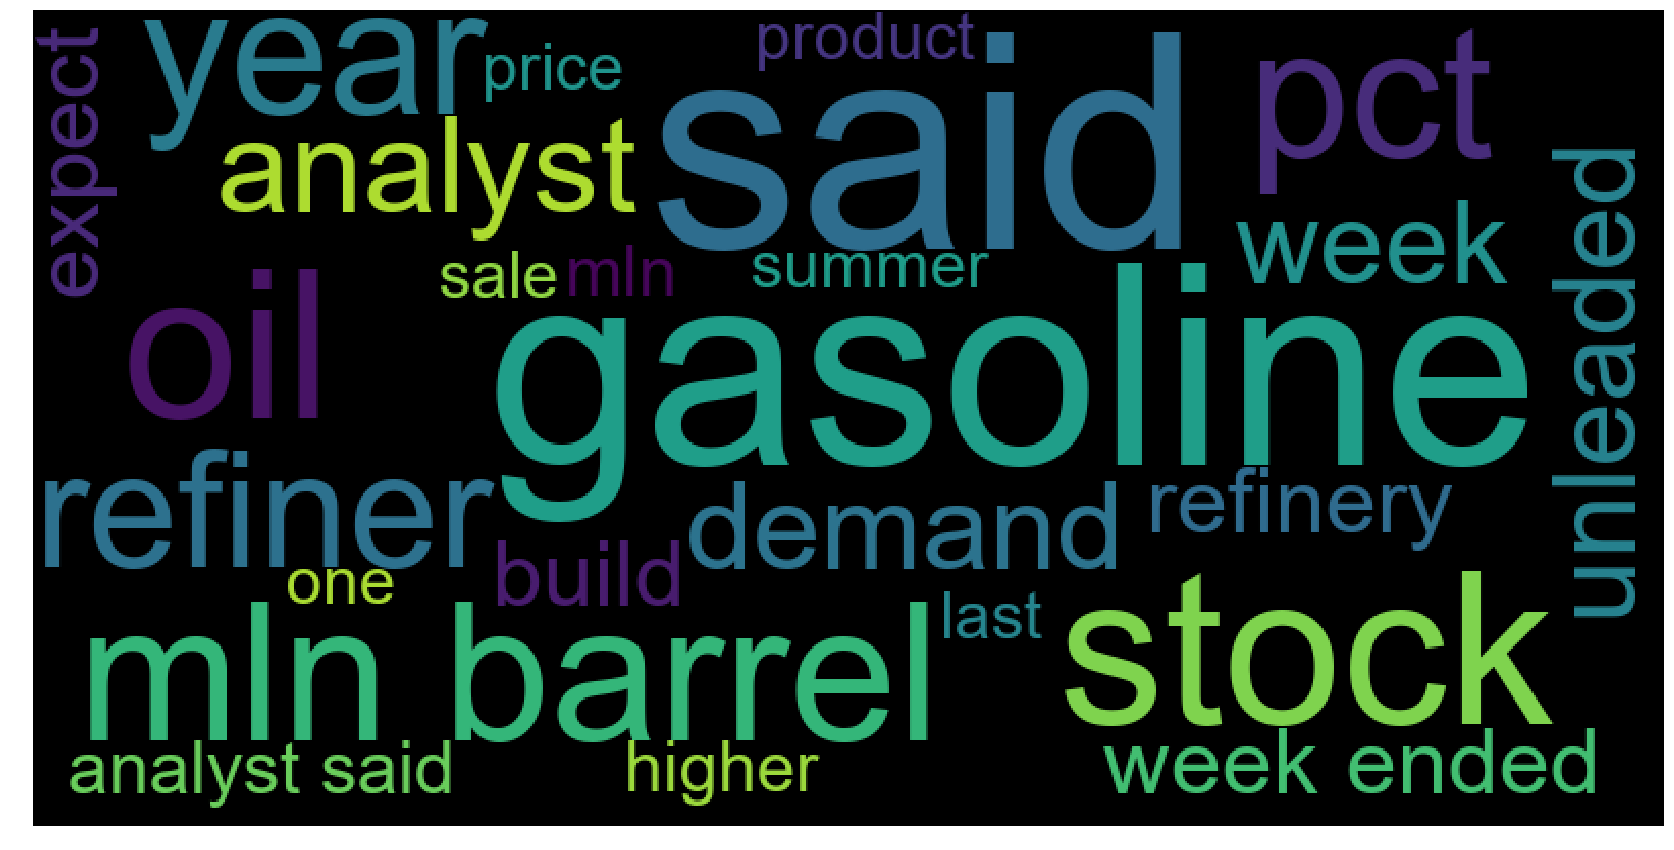

In [353]:
wc(qry='Gasoline Sales')

# Timeline

* De eerste tien resultaten gesorteerd op datum
    * De titels zijn te lang
    * De eerste twee woorden als indicator

# Timeline

In [368]:
def tl(qry=False,plc=False):
    dates = []
    names = []

    test = msearch('ms','docs', query=qry, place=plc)
    for article in test['responses'][0]['hits']['hits']:
        date = article['_source']['date']
        name = str(article['_source']['tokens'][0]) + ' ' + str(article['_source']['tokens'][1])

        dates.append(date)
        names.append(name)

    dates = [datetime.strptime(ii, "%d-%b-%Y %H:%M:%S.%f") for ii in dates]
    return (dates, names)

In [369]:
def tlshow(qry=False,plc=False):
    # Took heavy inspiration from the following tutorial in order to create a timeline in MatPlotLib
    # https://matplotlib.org/gallery/lines_bars_and_markers/timeline.html

    levels = np.array([-5, -3, -1, 1, 3, 5, -4, -2, 2, 4])
    fig, ax = plt.subplots(figsize=(10, 5))

    dates, names = tl(qry,plc)
    
    # Create the base line
    start = min(dates)
    stop = max(dates)
    ax.plot((start, stop), (0, 0), 'k', alpha=.5)

    # Iterate through releases annotating each one
    for ii, (iname, idate) in enumerate(zip(names, dates)):
        level = levels[ii % 6]
        vert = 'top' if level < 0 else 'bottom'

        # Add little nodes to the timeline
        ax.scatter(idate, 0, s=100, facecolor='w', edgecolor='k', zorder=9999)

        # Plot a line up to the text
        ax.plot((idate, idate), (0, level), c='r', alpha=.7)

        # Give the text a faint background and align it properly
        ax.text(idate, level, iname,
                horizontalalignment='right', verticalalignment=vert, fontsize=14,
                backgroundcolor=(1., 1., 1., .3))

    # Set the title
    ax.set(title="Megasearch results")

    # Set the x-axis
    ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    fig.autofmt_xdate()

    # Remove frame for a cleaner look
    plt.setp((ax.get_yticklabels() + ax.get_yticklines() + list(ax.spines.values())), visible=False)
    plt.show()

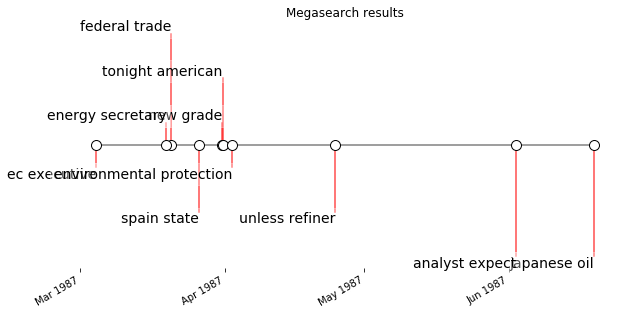

In [370]:
tlshow(qry='Gasoline Sales')

# Faceted Search

In [276]:
serp(plc=['Japan', 'USA'])

10 best hits in: 13 ms.


JAPANESE ECONOMIST SEES STABLE YEN/DOLLAR RATES

['japan', 'usa']


JAPAN LIKELY TO LET U.S. BANKS DEAL SECURITIES

['japan', 'usa']


JAPAN, U.S. SET TO BEGIN HIGH-LEVEL TRADE TALKS

['japan', 'usa']


ECONOMIC SPOTLIGHT - EUROYEN BOND ISSUES INCREASE

['japan', 'usa']


JAPANESE MINISTRY DENIES EXPORT QUOTA FOR DAIHATSU

['japan', 'usa']


U.S. TELLS JAPAN TO DO MORE TO CUT TRADE SURPLUS

['japan', 'usa']


BALDRIGE SAYS U.S. MAY RETALIATE ON KANSAI

['usa', 'japan']


YEUTTER SAYS BUDGET CUT KEY TO BETTER U.S. TRADE

['usa', 'japan']


FEDERAL EXPRESS TENTATIVELY GETS US/TOKYO ROUTE

['usa', 'japan']


FOREIGN BROKERS MAY GET MORE ACCESS TO JAPAN BONDS

['usa', 'japan']



<h2>Requirements</h2>

<p>Each of the following points <strong>must</strong> be addressed. Create a seperate page on the wiki for each point. Make sure these pages can be found from the menu of your wiki. 
        Explain what you did, and exemplify with links to screenshots/a working system.</p>
        <ol>
        <li>Search as we know it from Google. Give a result page (SERP), with links to the documents and some description of each hit.</li>
            <li>Advanced search. Let a user be able to search in several fields, also in several fields simulteanously. Queries like "return articles with a title  about XXX  and which are   about YYY in the period ZZZ" should be possible.
             </li>
        <li>Do one of the following:
            <ol><li>Represent the hits of a query with a wordcloud of 25-50 informative words. The wordcloud should somehow summarise what the collection has to say about the query.
            You may think of these words as words that you could add to the query in order to improve recall (blind relevance feedback/query expansion). </li>
                <li>Represent each document   with a word-cloud. </li></ol>
        <br/>You can use several techniques to get rid of high frequency, but meaningless words: of course IDF, but also mutual information (see 13.5.1), or of course the technique from the paper by Kaptein et al on wordclouds.
        </li>
          <!--  <li>Group (nearly) identical documents. It is bad if two or more of the precious places of your top ten hits are occupied by near identical copies of a document.
            Even more so if it is not relevant! So, get rid of these, by grouping them for instance. You get an idea of these duplicates if you search for "neuken".</li>
            -->
            <li>Give next to a traditional list of results, a timeline in which you indicate how many hits there are over time.</li>
            <li>Provide Faceted Search next to the traditional list of results. For the "Reuters" collection, use the Category information as facet values.</li>
            <li><strong>Evaluate your results</strong> Let 2 persons assess the relevancy of the top 10 documents for <strong>5 different queries</strong>. Compute Cohen's kappa. Determine the average precision at 10 for your system based on these 5 queries, and the two relevance assesments. 
                Also plot the P@10 (for both judges) for each query, showing differences in hard and easy queries.  
                Describe clearly how you solved differences in judgements.
            <br/>
            Create your queries in the following format:
<pre>
&lt;topic number="6"  >
    &lt;query>kcs&lt;/query>
    &lt;description>Find information on the Kansas City Southern railroad.
    &lt;/description>

&lt;/topic>

&lt;topic number="16"  >
    &lt;query>arizona game and fish&lt;/query>
    &lt;description>I'm looking for information about fishing and hunting
    in Arizona.
    &lt;/description>
&lt;/topic>
</pre>
    So, both provide the actual query, and a description of the information need that was behind the query.
    <br/>
    Give a small set of clear guidelines for judging the results, and let your judges follow these guidelines.
    <br/>
    It is far more interesting to have difficult queries (both for the search engine and for the judges) than to have queries on which all ten retrieved documents are relevant.
    So, try to create a good list of information needs.
<br/>
Change the ranking of your system, compute the average precision at 10 using your 5 queries, compare the results to your old system, and EXPLAIN what is going on.
</li>

</ol>

<h2>Presentation</h2>
<p>During your presentation you should have a live working search engine, that you demonstrate on the spot. Your presentation should be structured so that you will show all  requirements.
You will be asked to show how your system works using information needs coming  from the audience.</p>
<p>**Hint:** focus on a special aspect of your project. Everyone has done something similar, so your audience knows what was hard and what was terrible. Pick something you think will interest them.</p>


<h2>How you will be marked</h2>
<ul>
    <li>Sent the URL of your guthub wiki to Maarten Marx BEFORE the presentation.</li>
    <li>The first page of the wiki should contain:
        <ol>
            <li>The names and student numbers of the project members</li>
            <li>A link to the slides of your presentation</li>
            <li>A table of contents, with links to pages on the wiki adressing one of each of the "must-have" points listed above.
            <br/>During grading, you will receive points for each of the points. So make it crystal clear where they are adressed in your wiki. Use one page per point.</li>


</ol>
</li>
<li>The page for each point should contain, all rather briefly,
<ol>
<li>What you did and why you choose to do it in your special way.</li>
<li>Examples of what works, and what does not work (very well).</li>
<li>An evaluation of the quality of your work in 3-4 sentences.</li>
</ol></li>
<li>Clickable links to a live working demo are <strong>highly appreciated</strong>. </li>
</ul>


<h2>How your grade is computed?</h2>
You get a grade between 0 and 1 for each of the 6 points plus for the presentation. 
They are weighted as follows to arrive at your final grade.
<pre>
1: .1
2: .2
3: .2
4: .1
5: .1
6: .2
presentation : .1
</pre>


# Geplande functionaliteit

<img style="float: right;" src='https://i2.wp.com/daantor.com/wp-content/uploads/2017/02/network-graph.png?w=589&ssl=1' width='500'>

- Maat van node representeert rank/'goodness'
- Afstand\hoeveelheid verbindingen tussen nodes representeert similarity
<br>
<br>
- Soortgelijke resultaten samen gegroepeerd; klopt het resultaat compleet niet kan de gebruiker meteen verder naar een andere cluster
- Geen scheiding in rank; hebben twee resultaten een soortgelijke 'goodness', dan zijn de nodes ongeveer even groot
- Mooi!
<br>
<br>
- Makkelijk te implementeren in Python (networkx), moeilijk te implementeren in HTML (links, clickboxes)

## Bedankt voor jullie aandacht.

In [158]:
#search_arr.append({"_source": [ "title", "text" ]})
#search_arr.append({"query": {"match" : {"tokens" : str(' '.join(stemtext(query)))}}})
#search_arr.append({"query": {"match" : {"text" : query}}, "highlight" : {"fields" : {"text" : {}}}})
#search_arr.append({"filter": [{"term" : {"places" : str(plac).lower()}} for plac in place] })

def query(inpt):
    q= {
        "query": {
            "match": {
                "tokens": str(' '.join(stemtext(inpt)))
            }
        }
    }

    q1 = {
        "query" : {
            "match": { "text": inpt }
        },
        "highlight" : {
            "fields" : {
                "text" : {}
            }
        }
    }
    res = es.search(index="ms", body=q1)
    return res['hits']['hits']
test = query("Gasoline Sales Japan")
print(test[0]['highlight']['text'][0])

Formula Shell has achieved strong <em>sales</em> in <em>Japan</em> despite a
higher price than regular octane <em>gasoline</em>,
